In [1]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba as nb
import ot
import time


In [2]:
parent_path='/home/baly/projects/Sliced_opt/code'
sys.path.append(parent_path)
os.chdir(parent_path)
from sopt.library import *
from sopt.lib_shape import *
from sopt.lib_ot import *   
from sopt.sliced_opt import *   


/home/baly/projects/Sliced_opt/code/sopt/sliced_opt.py:132: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, A))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/Sliced_opt/code/sopt/sliced_opt.py:162: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/Sliced_opt/code/sopt/lib_shape.py:244: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  beta=vec_mean(T)-vec_mean(scalar*S.dot(rotation))
/home/baly/projects/Sliced_opt/code/sopt/lib_shape.py:260: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, F))
  T_hat_theta=np.dot(theta,T_hat.T)
/home/baly/projects/Sliced_opt/code/sopt/lib_shape.py:293: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, c

In [3]:
#print('here')
@nb.njit(['Tuple((float32[:,:,:],float32[:],float32[:,:]))(float32[:,:],float32[:,:],int64,int64)'])
def sopt_main_32(S,T,n_iterations,N0):
    n,d=T.shape
    N1=S.shape[0]
    # initlize 
    rotation=np.eye(d,dtype=np.float32)    
    scalar=np.float32(1) 
    beta=vec_mean_32(T)-vec_mean_32(scalar*S.dot(rotation)) 
    #paramlist=[]
    projections=random_projections_32(d,n_iterations,1)
    mass_diff=0
    b=np.float32(np.log((N1-N0+1)/1))
    Lambda=6*np.sum(beta**2)
    rotation_list=np.zeros((n_iterations,d,d),dtype=np.float32)
    scalar_list=np.zeros((n_iterations),dtype=np.float32)
    beta_list=np.zeros((n_iterations,d),dtype=np.float32)
    T_hat=S.dot(rotation)*scalar+beta
    Domain_org=arange(0,N1)
    Delta=np.float32(Lambda/8)
    lower_bound=np.float32(Lambda/10000)
    for i in range(n_iterations):
#        print('i',i)
        theta=projections[i]
        T_hat_theta=np.dot(theta,T_hat.T)
        T_theta=np.dot(theta,T.T)
        
        T_hat_indice=T_hat_theta.argsort()
        T_indice=T_theta.argsort()
        T_hat_s=T_hat_theta[T_hat_indice]
        T_s=T_theta[T_indice]
        c=cost_matrix(T_hat_s,T_s)
        obj,phi,psi,piRow,piCol=solve_opt_32(c,Lambda)
        L=piRow.copy()
        L=recover_indice(T_hat_indice,T_indice,L)
        
      #debug 
        # if L.max()>=n:
        #     print('error')
        #     return T_hat_theta,T_theta,Lambda
        #     break
        
        #move T_hat
        Domain=Domain_org[L>=0]
        mass=Domain.shape[0]
        if Domain.shape[0]>=1:
            Range=L[L>=0]
            T_hat_take_theta=T_hat_theta[Domain]
            T_take_theta=T_theta[Range]
            T_hat[Domain]+=np.expand_dims(T_take_theta-T_hat_take_theta,1)*theta

        T_hat_take=T_hat[Domain]
        S_take=S[Domain]
        
        # compute the optimal rotation, scaling, shift
        rotation,scalar=recover_rotation_32(T_hat_take,S_take)
        scalar=np.float32(np.sqrt(np.trace(np.cov(T_hat_take.T))/np.trace(np.cov(S_take.T))))
        beta=vec_mean_32(T_hat_take)-vec_mean_32(scalar*S_take.dot(rotation))
        T_hat=S.dot(rotation)*scalar+beta
        
        rotation_list[i]=rotation
        scalar_list[i]=scalar
        beta_list[i]=beta
        N=(N1-N0)*1/(1+b*(i/n_iterations))+N0
        mass_diff=mass-N
        if mass_diff>N*0.009:
            Lambda-=Delta 
        if mass_diff<-N*0.003:
            Lambda+=Delta
            Delta=Lambda*1/8
        if Lambda<Delta:
            Lambda=Delta
            Delta=Delta*1/2
        if Delta<lower_bound:
            Delta=lower_bound
        # if i&50==0:
        #     print('scalar',scalar)
        #     print('lambda',Lambda)
        #     print('delta',Delta)
        #     print('N',N)
        #     print('mass_diff',mass_diff)
    return rotation_list,scalar_list,beta_list   
print('done')

done


In [4]:
def get_noise(Y0,Y1):
    N=Y1.shape[0]
    data_indices=[]
    noise_indices=[]
    for j in range(N):
        yj=Y1[j]
        if yj in Y0:
            data_indices.append(j)
        else:
            noise_indices.append(j)
    return np.array(data_indices),np.array(noise_indices)

def init_image(X_data,X_noise,Y_data,Y_noise,image_path,name):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_data[:,0]+5,X_data[:,1],X_data[:,2]-10,alpha=.5,c='C2',s=2,marker='o')
    ax.scatter(X_noise[:,0]+5,X_noise[:,1],X_noise[:,2]-10,alpha=.5,c='C2',s=10,marker='o')
    ax.scatter(Y_data[:,0]+5,Y_data[:,1],Y_data[:,2]-10,alpha=0.5,c='C1',s=2,marker='o')
    ax.scatter(Y_noise[:,0]+5,Y_noise[:,1],Y_noise[:,2]-10,alpha=.5,c='C1',s=10,marker='o')
    ax.set_facecolor('black') 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(True)
    ax.axis('off')
    
    # whitch_castle 
    # x+5, z-10
    ax.set_xlim([-38,38])
    ax.set_ylim([-38,38])
    ax.set_zlim([-38,38])
    ax.view_init(45,120)
    
    
    #mumble_sitting 
    # ax.set_xlim([-66,66])
    # ax.set_ylim([-66,66])
    # ax.set_zlim([-66,66])
    # ax.axis('off')
    # ax.view_init(-20,10,'y')

    
    #dragon +bunny     
    # bunny y-0.05,
    # ax.set_xlim([-.25,.25])
    # ax.set_ylim([-.25,.25])
    # ax.set_zlim([-.25,.25])
    # ax.axis('off')
    # ax.view_init( 90, -90)
    

    plt.savefig(image_path+'/'+name+'.png',dpi=200,format='png',bbox_inches='tight')
    plt.show()
    plt.close()
    
    

def regular_image(X_data,X_noise,Y_data,Y_noise,image_path,name):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_data[:,0]+3,X_data[:,1],X_data[:,2]-15,alpha=.3,c='C2',s=5,marker='o')
    ax.scatter(X_noise[:,0]+3,X_noise[:,1],X_noise[:,2]-15,alpha=.5,c='C2',s=15,marker='o')
    ax.scatter(Y_data[:,0]+3,Y_data[:,1],Y_data[:,2]-15,alpha=.9,c='C1',s=6,marker='o')
    ax.scatter(Y_noise[:,0]+3,Y_noise[:,1],Y_noise[:,2]-15,alpha=.5,c='C1',s=15,marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('black') 
    ax.grid(True)
    
    # castle,   
    #x+3, z-15 
    ax.set_xlim([-20,20])
    ax.set_ylim([-20,20])
    ax.set_zlim([-20,20])
    ax.view_init(45,120)
#    ax.view_init(0,10,'y')


    # #mumble_sitting, bunny  
    # y-10
    # ax.set_xlim([-36,36])
    # ax.set_ylim([-36,36])
    # ax.set_zlim([-36,36])
    # ax.view_init(-20,10,'y')
    #ax.view_init( 90, -90)
     
    #dragon, bunny 
    #dragon y-0.1
    #bunny, x+0.02, y-0.1    
    # ax.set_xlim([-.1,.1])
    # ax.set_ylim([-.1,.1])
    # ax.set_zlim([-.1,.1])

    # ax.view_init( 90, -90)
    # fig.set_facecolor('black')
    
    plt.savefig(image_path+'/'+name+'.png',dpi=200,format='png',bbox_inches='tight')
    plt.show()
    plt.close()

In [5]:
#save the parameter
def save_parameter(rotation_list,scalar_list,beta_list,save_path):
    paramlist=[]
    N=len(rotation_list)
    for i in range(N):
        param={}
        param['rotation']=rotation_list[i]
        param['beta']=beta_list[i]
        param['scalar']=scalar_list[i]
        paramlist.append(param)
    torch.save(paramlist,save_path)
    return paramlist

In [6]:
# select data 
item_list=['/stanford_bunny','/dragon','/mumble_sitting','/witchcastle']

#exp_num=item
num=3 # other choices 0,1,2
item=item_list[num]
label_L=['0','1']
L=['/10k','/9k']
time_list={}
(label,per_s) =('0','-5p') # other choices ('0','-7p'), ('0','-5p'), ('1','-7p')

n_point=L[int(label)]    
data_path=parent_path+'/experiment/shape_registration/data/test/saved'
save_path='experiment/shape_registration/result'+item+n_point+per_s
data=torch.load(data_path+item+'.pt')

try:
    time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')
except:
    time_list32={}
    torch.save(time_list,'experiment/shape_registration/result/time_list32.pt')
#print('data',item)
#print('experiment/shape_registration/result'+str(item)+'time_list.pt')
#print('time_list',time_list)
#print('data is',item)
#T0=data['T0'].to(torch.float64)
#S0=data['S0'+label].to(torch.float64)
#T1=data['T1'+per_s].to(torch.float64)
#S1=data['S1'+label+per_s].to(torch.float64)


In [ ]:
#our method
#load the data 
time_dict={}

T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
print('sopt')

T=T1.numpy().copy()
S=S1.numpy().copy()
N0=S0.shape[0]
start_time=time.time()
n_iterations=3000
rotation_list,scalar_list,beta_list =sopt_main_32(S,T,n_iterations,N0)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32['sopt'][item+n_point+per_s]=result
print('per_s',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
paramlist=save_parameter(rotation_list,scalar_list,beta_list,'experiment/shape_registration/result/'+item+n_point+per_s+'/sopt_param.pt')
print(paramlist[-1])

experiment/shape_registration/result/witchcastle/10k-5p/sopt
label 0
per_s -5p
method /sopt


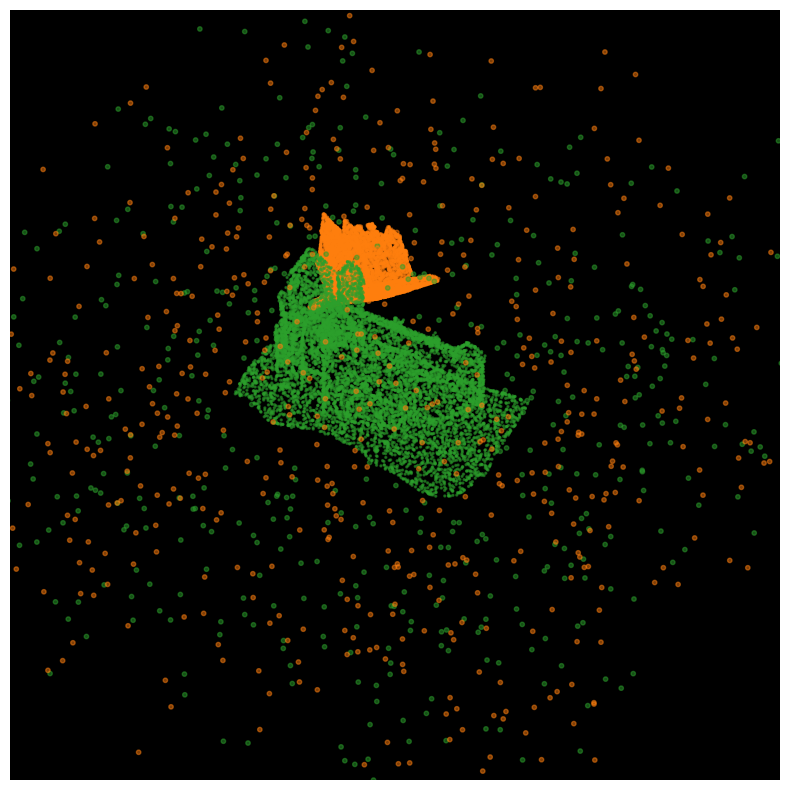

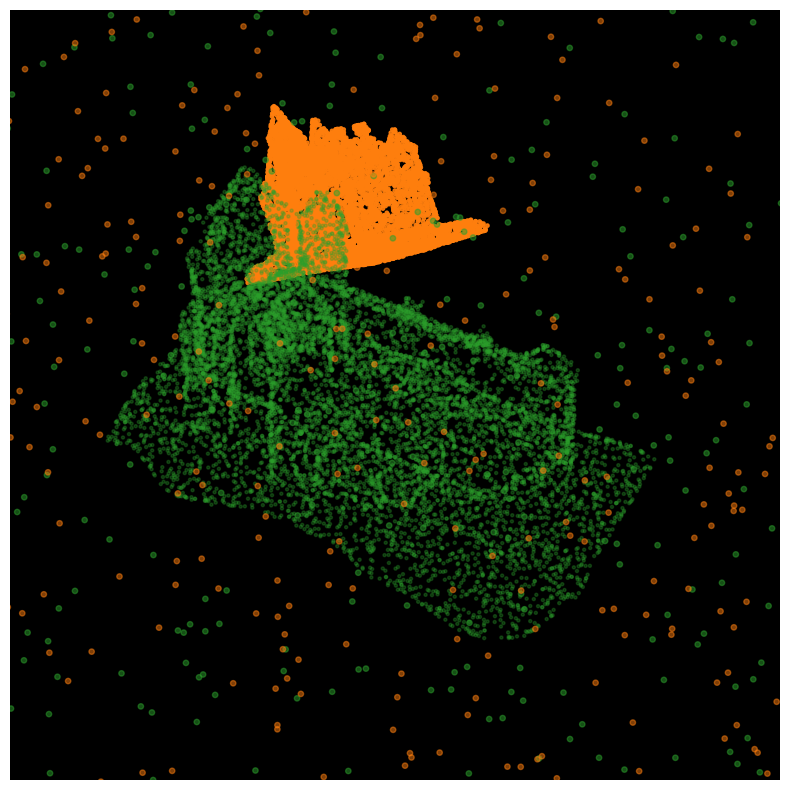

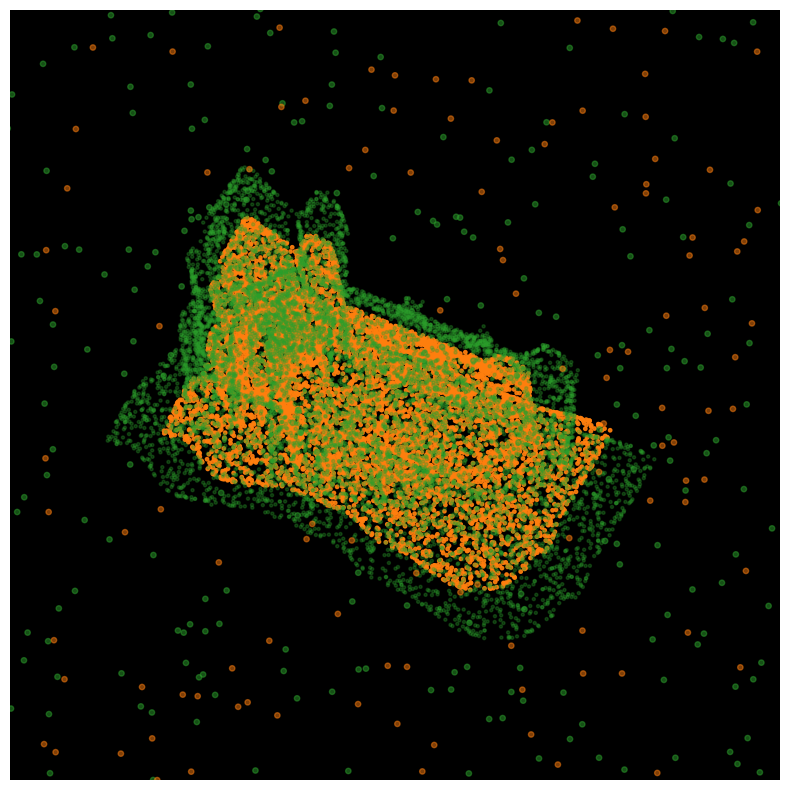

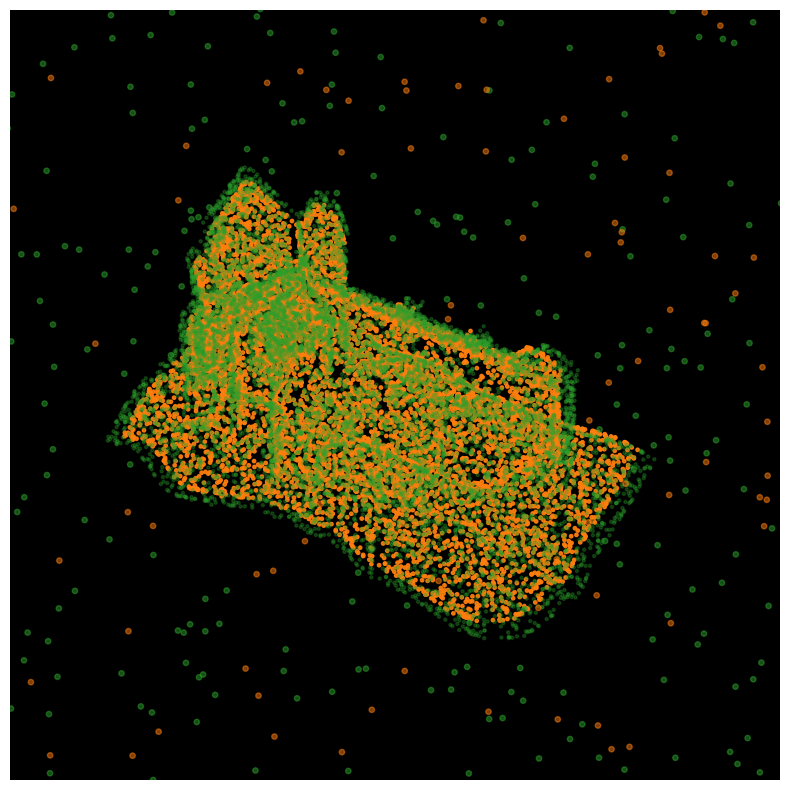

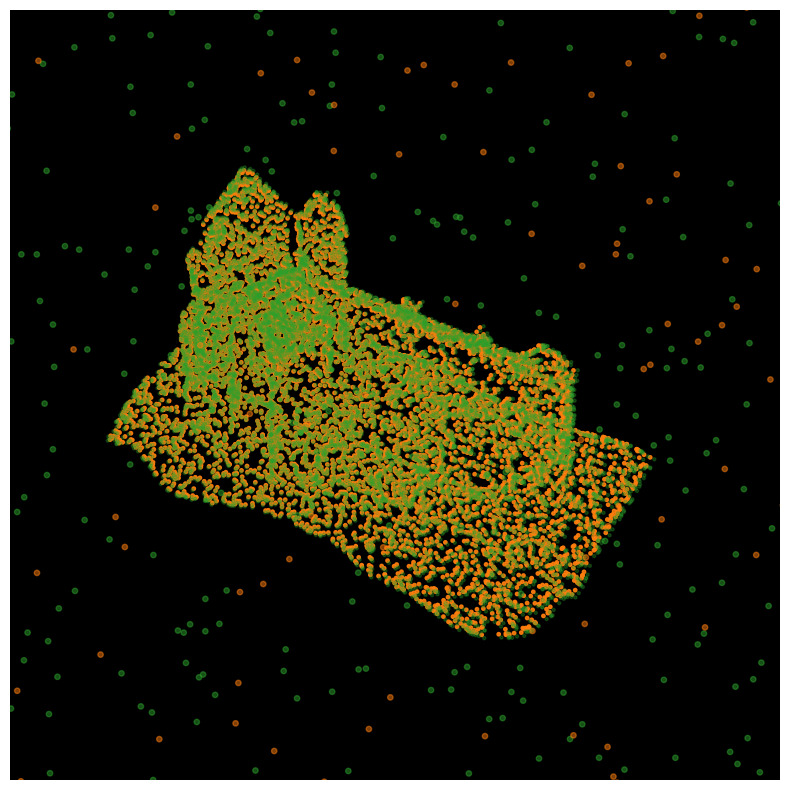

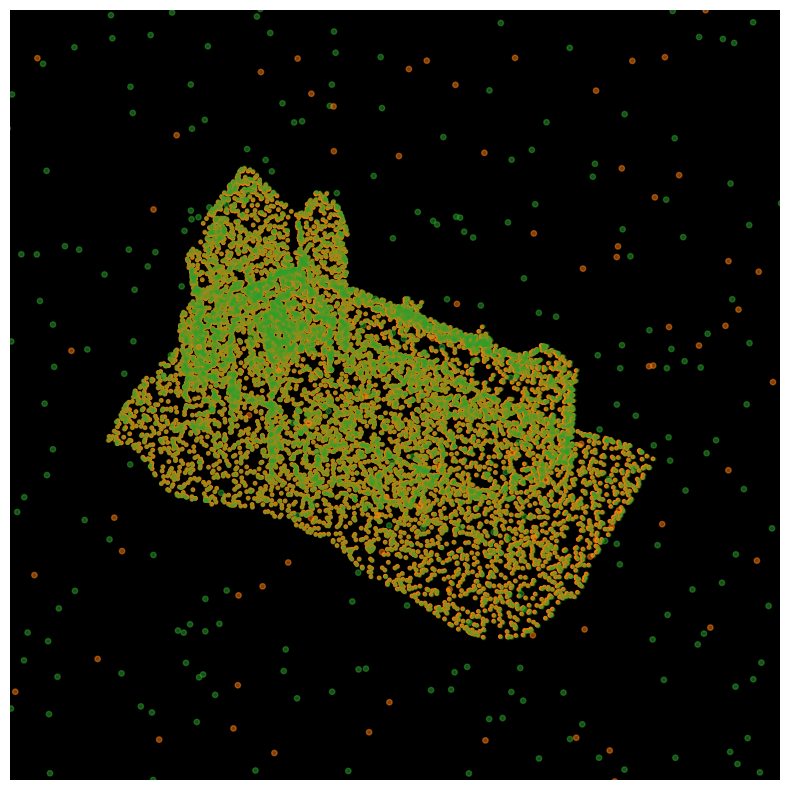

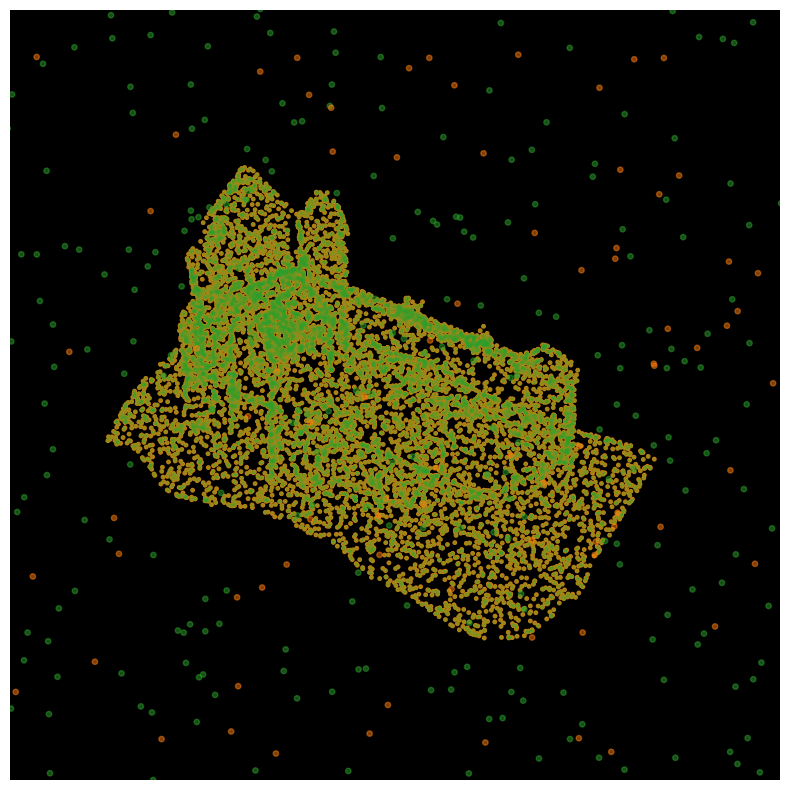

In [25]:
#visualize the result
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')
method='/sopt'
image_path='experiment/shape_registration/result'+item+n_point+per_s+method
print(image_path)
print('label',label)
print('per_s',per_s)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function regular_image to have a better plot  
regular_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+per_s]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    regular_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))

In [ ]:
# SPOT Boneel 
#load the data 
time_dict={}
method='/spot'
T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
print('spot')

T=T1.numpy().copy()
S=S1.numpy().copy()
N0=S0.shape[0]
n_projections=20
n_iterations=150
start_time=time.time()
rotation_list,scalar_list,beta_list =spot_bonneel_32(S,T,n_projections,n_iterations)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32['spot'][item+n_point+per_s]=result
print('per_s',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
save_parameter(rotation_list,scalar_list,beta_list,'experiment/shape_registration/result/'+item+n_point+per_s+method+'_param.pt')

In [ ]:
print('hello')

In [ ]:
#visualize the result 
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')
method='/spot'
image_path='experiment/shape_registration/result'+item+n_point+per_s+method
print(image_path)
print('label',label)
print('per_s',per_s)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function regular_image to have a better plot  
regular_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+per_s]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    regular_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))

In [ ]:
# icp-du
#load the data 
method='/icp-du'
time_dict={}

T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
print('icp-du')

T=T1.numpy().copy()
S=S1.numpy().copy()
N0=S0.shape[0]
#n_projections=20
n_iterations=300
start_time=time.time()
rotation_list,scalar_list,beta_list =icp_du_32(S,T,n_projections)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32['icp-du'][item+n_point+per_s]=result
print('per_s',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
save_parameter(rotation_list,scalar_list,beta_list,'experiment/shape_registration/result/'+item+n_point+per_s+method+'_param.pt')

In [ ]:
#visualize the result 
method='/icp-du'
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')

image_path='experiment/shape_registration/result'+item+n_point+per_s+method
print(image_path)
print('label',label)
print('per_s',per_s)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function regular_image to have a better plot  
regular_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+per_s]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    regular_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))

In [ ]:
# icp-umeyama
#load the data 
method='/icp-umeyama'
time_dict={}

T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
print('icp-umeyama')

T=T1.numpy().copy()
S=S1.numpy().copy()
N0=S0.shape[0]
#n_projections=20
n_iterations=300
start_time=time.time()
rotation_list,scalar_list,beta_list =icp_du_32(S,T,n_projections)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32[method[1:]][item+n_point+per_s]=result
print('per_s',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
save_parameter(rotation_list,scalar_list,beta_list,'experiment/shape_registration/result/'+item+n_point+per_s+method+'_param.pt' #'/icp-umeyama_param.pt')

In [ ]:
#visualize the result 
method='/icp-umeyama'
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')

image_path='experiment/shape_registration/result'+item+n_point+per_s+method
print(image_path)
print('label',label)
print('per_s',per_s)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0'+label].to(torch.float32)
T1=data['T1'+per_s].to(torch.float32)
S1=data['S1'+label+per_s].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function regular_image to have a better plot  
regular_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+per_s]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    regular_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))